In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict

import matplotlib.pyplot as plt

import pickle
import warnings

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import mannwhitneyu, spearmanr
from sklearn.base import clone
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold

from metaorf.modeling.etl import generate_orf_id, load_features, load_truth_datasets
from metaorf.modeling.ensemble import Dataset, plot_roc_pr, plot_roc, plot_pr

from pathlib import Path

pd.set_option('display.max_columns', 100)

warnings.filterwarnings('ignore')

In [2]:
data_dir = Path('../data').absolute()

def download_feature_set(experiment_name, local_path):
    orf_path = f"s3://velia-piperuns-dev/{experiment_name}/output/{experiment_name}_orf_features.csv"
    local_path = f"{local_path}/{experiment_name}_orf_features.csv"
    cmd = f"aws s3 cp {orf_path} {local_path}"
    print(cmd)
    os.system(cmd)
    return local_path

for experiment_name in open(f"{data_dir}/experiments.txt"):
    experiment_name = experiment_name.strip().strip("/")
    download_feature_set(experiment_name, data_dir)

### Load truth datasets

In [63]:
#truth_pos_df = pd.read_csv(data_dir.joinpath('truthset_positives.240227.tsv'), sep='\t')
#truth_neg_df = pd.read_csv(data_dir.joinpath('truthset_negatives.240227.tsv'), sep='\t')
#truth_pos_df['orf_id'] = truth_pos_df.apply(lambda x: generate_orf_id(x), axis=1)
#truth_neg_df['orf_id'] = truth_neg_df.apply(lambda x: generate_orf_id(x), axis=1)
#truth_df = shuffle(pd.concat([truth_pos_df, truth_neg_df]))

In [95]:
truth_df = shuffle(pd.read_csv("s3://velia-piperuns-dev/summary/truthset_batch1to4_240411_2.txt", sep='\t'))
truth_df['orf_id'] = truth_df.apply(lambda x: generate_orf_id(x), axis=1)

In [96]:
#batch2 = [name for name in set(truth_df["ORF.type"]) if (name.startswith("batch3"))]
truth_df = truth_df[~ truth_df["ORF.type"].isin(batch2)]

In [ ]:
truth_df

,orf.name,ORF.type,score.(Agg),score.(iPSC),score.(MB1),score.(Gaertner),coverage.(Agg),coverage.(iPSC),coverage.(MB1),coverage.(Gaertner),start.(Agg),start.(iPSC),start.(MB1),start.(Gaertner),end.(Agg),end.(iPSC),end.(MB1),end.(Gaertner),comment,match.to.riboseq.call,chrom,chromStart,chromEnd,orf.name.1,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,orf_id
5397,UP623,batch3_visual.neg,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr12,21501923,21515707,UP623,0,+,21501922,21515707,"0,0,0",5,"25,92,179,82,39,","0,4961,6459,10371,13745,",chr12_21501923_21515707_+_21501923-21501948|21...
5496,UP765,batch3_visual.neg,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr1,27666380,27669314,UP765,0,-,27666379,27669314,"0,0,0",4,"95,150,78,82,","0,1845,2077,2852,",chr1_27666380_27669314_-_27666380-27666475|276...
5048,UP212,batch3_visual.neg,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr6,106971660,106973885,UP212,0,-,106971659,106973885,"0,0,0",2,"174,216,","0,2009,",chr6_106971660_106973885_-_106971660-106971834...
4992,UP160,batch3_visual.neg,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr19,46608270,46609153,UP160,0,+,46608269,46609153,"0,0,0",4,"70,107,136,29,","0,211,575,854,",chr19_46608270_46609153_+_46608270-46608340|46...
5446,UP708,batch3_visual.neg,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr16,3022862,3023505,UP708,0,-,3022861,3023505,"0,0,0",3,"136,129,32,","0,370,611,",chr16_3022862_3023505_-_3022862-3022998|302323...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4900,UP37,batch3_visual.neg,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr10,72223914,72233116,UP37,0,+,72223913,72233116,"0,0,0",2,"142,116,","0,9086,",chr10_72223914_72233116_+_72223914-72224056|72...
4935,UP84,batch3_visual.neg,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr21,25724639,25729794,UP84,0,-,25724638,25729794,"0,0,0",3,"38,125,164,","0,586,4991,",chr21_25724639_25729794_-_25724639-25724677|25...
5499,UP769,batch3_visual.neg,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr11,298500,299490,UP769,0,-,298499,299490,"0,0,0",2,"213,186,","0,804,",chr11_298500_299490_-_298500-298713|299304-299490
5518,UP788,batch3_visual.neg,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr9,112687537,112716485,UP788,0,-,112687536,112716485,"0,0,0",4,"96,91,103,25,","0,1989,6593,28923,",chr9_112687537_112716485_-_112687537-112687633...


(0, 856, 0.0)

In [110]:
#truth_pos_df['orf_id'] = truth_pos_df.apply(lambda x: generate_orf_id(x), axis=1)
#truth_neg_df['orf_id'] = truth_neg_df.apply(lambda x: generate_orf_id(x), axis=1)

#truth_df = shuffle(pd.concat([truth_pos_df, truth_neg_df]))

In [ ]:
######
# Check the data
# 50% positive????
######

In [115]:
datasets = load_truth_datasets(truth_df, data_dir, overwrite=True, dataset_names=['iPSC', 'MB1', 'Gaertner'])

5217    batch3_visual.neg
5293    batch3_visual.neg
5026    batch3_visual.neg
5316    batch3_visual.neg
5023    batch3_visual.neg
              ...        
5324    batch3_visual.neg
5437    batch3_visual.neg
5221    batch3_visual.neg
5259    batch3_visual.neg
5499    batch3_visual.neg
Name: ORF.type, Length: 381, dtype: object
5048    batch3_visual.neg
5217    batch3_visual.neg
5293    batch3_visual.neg
4987    batch3_visual.neg
5026    batch3_visual.neg
              ...        
5437    batch3_visual.neg
5221    batch3_visual.neg
5259    batch3_visual.neg
5481    batch3_visual.neg
5499    batch3_visual.neg
Name: ORF.type, Length: 456, dtype: object
5217    batch3_visual.neg
5293    batch3_visual.neg
5026    batch3_visual.neg
5316    batch3_visual.neg
5023    batch3_visual.neg
              ...        
5081    batch3_visual.neg
5221    batch3_visual.neg
5259    batch3_visual.neg
5481    batch3_visual.neg
5499    batch3_visual.neg
Name: ORF.type, Length: 275, dtype: object


In [ ]:
dataset_name = 'all'
ds = datasets[dataset_name]
ds.X.reset_index(inplace=True, drop=True)

In [ ]:
len(ds.y)

In [ ]:
datasets

In [ ]:
sum(datasets["iPSC"].y)/ len(datasets["iPSC"].y)

In [ ]:
sum(ds.y)/ len(ds.y)

### Choose model

#### Gradient boosting classifier (standard)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 0.2, 0.5],
    'subsample': [0.8, 0.9, 1.0],
    'loss': ['deviance', 'exponential'],
}

gclf = RandomizedSearchCV(GradientBoostingClassifier(), param_grid, random_state=0, n_jobs=72, n_iter=10)
search = gclf.fit(ds.X, ds.y)
search.best_params_
classifier = GradientBoostingClassifier(**search.best_params_)

In [ ]:
search.best_params_

In [75]:
best_params = {'subsample': 0.9,
 'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 0.5,
 'max_depth': 10,
 'loss': 'exponential',
 'learning_rate': 0.05}

In [76]:
classifier = GradientBoostingClassifier(**best_params)
classifier_type = 'gb'

In [77]:
ds.model = classifier

In [78]:
with open(f'../data/top_model_{dataset_name}_gb.pkl', 'wb') as file:
    pickle.dump(ds, file)

In [79]:
def StratifiedByChrom(X):
    groups = [['chr1', 'chr6', 'chr11', 'chr16', 'chr21'],
            ['chr2', 'chr7', 'chr12', 'chr17', 'chr22'],
            ['chr3', 'chr8', 'chr13', 'chr18', 'chrX'],
            ['chr4', 'chr9', 'chr14', 'chr19', 'chr1'],
            ['chr5', 'chr10', 'chr15', 'chr20', 'chrY']]

    for group_idx in range(1, len(groups)):
        train_indice = X[~X["chrom_id"].isin(groups[group_idx])].index
        test_indice = X[X["chrom_id"].isin(groups[group_idx])].index
        print(group_idx, groups[group_idx])
        yield (group_idx, (train_indice, test_indice))

def predict(ds, classifier):
    for i, (train, test) in StratifiedByChrom(ds.X):
        print(set(ds.X.iloc[train]["chrom_id"]))
        print(set(ds.X.iloc[test]["chrom_id"]))
        X_train, X_test = ds.X.drop(columns=['chrom_id']).iloc[train], ds.X.drop(columns=['chrom_id']).iloc[test]
        y_train, y_test = ds.y[train], ds.y[test]
        cloned_classifier = clone(classifier)

        cloned_classifier.fit(X_train, y_train)
        y_pred = cloned_classifier.predict_proba(X_test)[:, 1]
        viz = roc_curve(y_test, y_pred)
        for i in range(100):
            print(y_test[i], y_pred[i])
        break

In [59]:
sum(ds.y)/ len(ds.y), len(ds.y), sum(ds.y)

(0.49019533038303065, 26212, 12849)

In [60]:
set(ds.X[ds.X["chrom_id"].isin(['chr1', 'chr6', 'chr11', 'chr16', 'chr21'])]["chrom_id"])

{'chr1', 'chr11', 'chr16', 'chr21', 'chr6'}

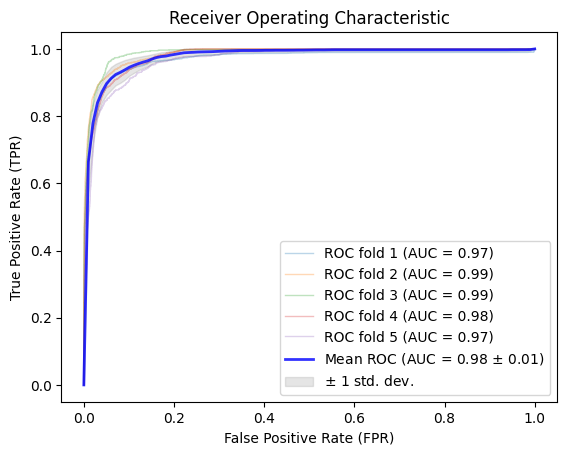

In [80]:
feature_importances, roc_pr_fig = plot_roc(ds, classifier)
roc_pr_fig.savefig(f'../figures/roc_curve_{ds.name}_{classifier_type}.png', dpi=200, bbox_inches='tight')

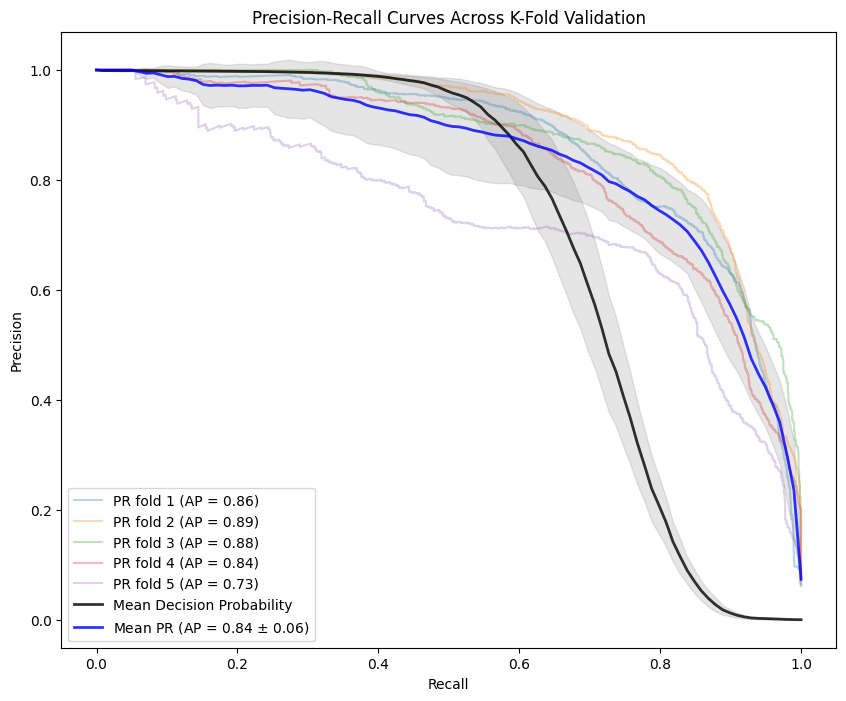

In [81]:
feature_importances, pr_fig = plot_pr(ds.X, ds.y, classifier, n_splits=5)
pr_fig.savefig(f'../figures/pr_curve_{ds.name}_{classifier_type}.png', dpi=200, bbox_inches='tight')

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
cloned_classifier = clone(classifier)
fig, [ax_roc, ax_pr] = plt.subplots(1, 2, figsize=(11, 5))

for i, (train, test) in enumerate(cv.split(ds.X, ds.y)):
    cloned_classifier.fit(ds.X.iloc[train], ds.y[train])
    fpr, tpr, roc_thresh = roc_curve(ds.y[test], cloned_classifier.predict_proba(ds.X.iloc[test])[:, 1])
    pr, rc, pr_thresh = precision_recall_curve(ds.y[test], cloned_classifier.predict_proba(ds.X.iloc[test])[:, 1])
    
    ax_roc.plot(fpr, tpr)
    ax_roc.plot(fpr, roc_thresh, color='black')

    ax_pr.plot(rc, pr)
    ax_pr.plot(rc, np.append(pr_thresh, 1), color='black')

fig.savefig(f'../figures/roc_pr_threshold_{dataset_name}_gb.png', dpi=200, bbox_inches='tight')

In [20]:
ds.X.drop(columns=['chrom_id']).columns

Index(['mean', 'sum', 'std', 'n_reads_orf_vs_transcript', 'pos_1_vs_0',
       'pos_2_vs_0', 'frames_1_vs_0', 'frames_2_vs_0', 'five_utr_vs_cds_mean',
       'five_utr_vs_cds_max', 'five_utr_vs_start_codon_mean',
       'five_utr_vs_start_codon_max', 'cds_utr_vs_start_codon_mean',
       'cds_utr_vs_start_codon_max', 'three_utr_vs_cds_mean',
       'three_utr_vs_cds_max', 'three_utr_vs_stop_codon_mean',
       'three_utr_vs_stop_codon_max', 'cds_utr_vs_stop_codon_mean',
       'cds_utr_vs_stop_codon_max', 'dist_neg_100', 'dist_neg_150',
       'dist_pos_100', 'dist_pos_150', 'price', 'ribotish', 'ribocode',
       'tis_transformer_score'],
      dtype='object')

In [32]:
fi_df = pd.DataFrame(feature_importances, columns=ds.X.drop(columns=['chrom_id']).columns)
medians = fi_df.median()
sorted_columns = medians.sort_values(ascending=False).index
sorted_df = fi_df[sorted_columns]
plot_df = fi_df.melt(var_name='Category', value_name='Value')

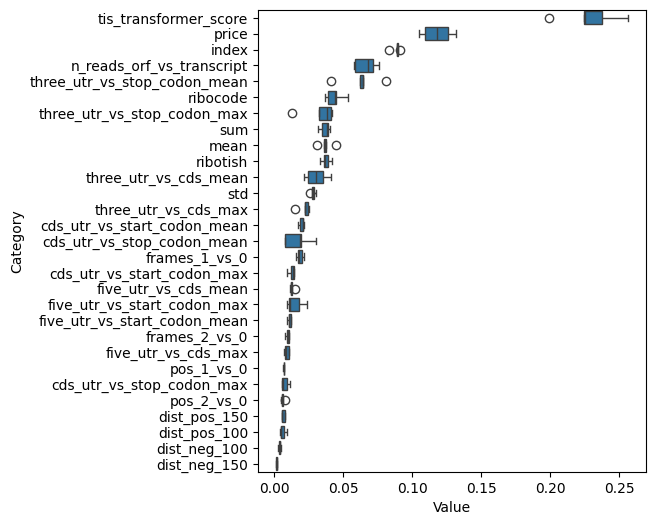

In [33]:
bplot = sns.boxplot(plot_df, y='Category', x='Value', order=sorted_df.columns)
bplot.figure.set_size_inches(5,6)
bplot.figure.savefig(f'../figures/feature_importance_impurity_{dataset_name}_{classifier_type}.png', dpi=200, bbox_inches='tight')

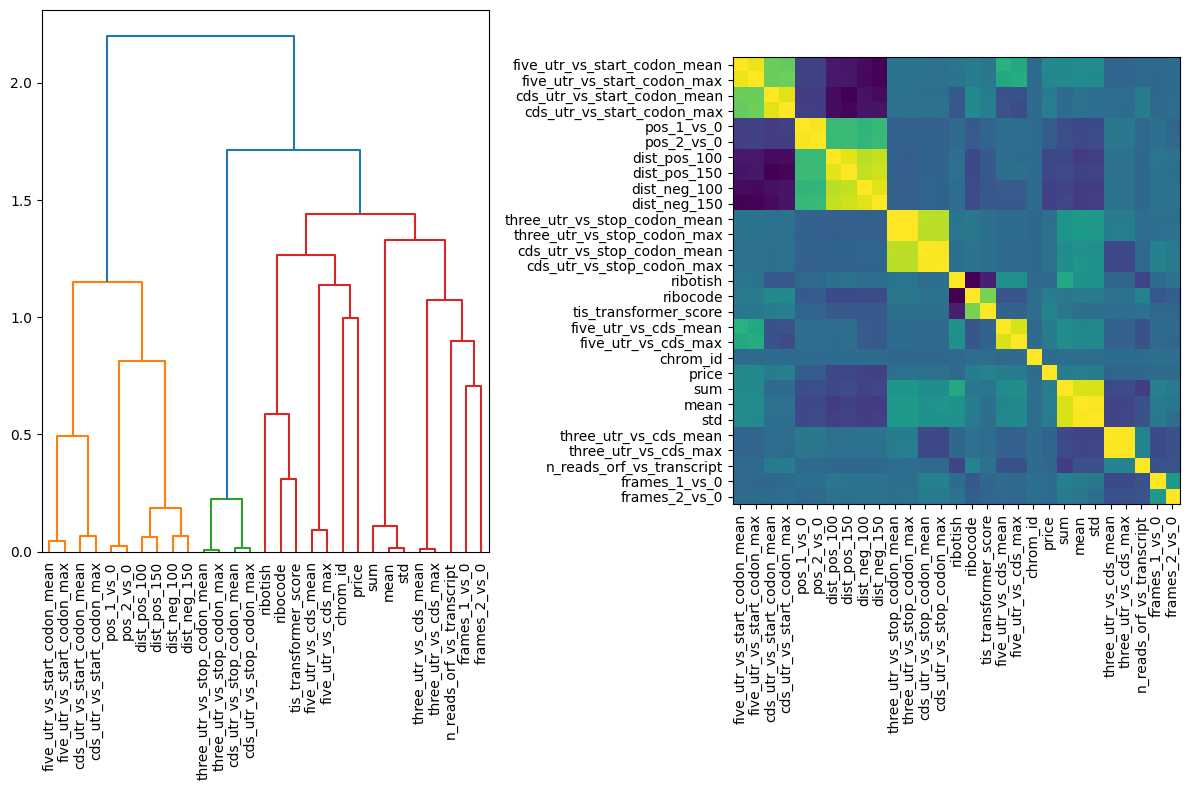

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(ds.X).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=ds.X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

In [ ]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=100, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

In [19]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = ds.X.columns[selected_features]

cloned_classifier = clone(classifier)
cloned_classifier.fit(ds.X[selected_features_names], ds.y)

fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(cloned_classifier, ds.X[selected_features_names], ds.y, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()
    

ValueError: could not convert string to float: 'chr1'